# Thinkful Capstone Project

## Determining the Drivers of Customer Satisfaction

The goal of this project was to look at automotive customer survey data to determine why customers provide high ratings on their surveys, using the open ended comments. 

The open ended comments on these surveys have been sorted into topics (called "perspectives" in this report) on a sentence-by-sentence basis, using proprietary text analysis software. A survey can have multiple perspectives attributed to it, due to the fact that customers can type at length about their experience and touch on many different topics (e.g. friendliness, professionalism, timeliness, etc.).

The rating scale question analyzed was a 0-10 scale question asking "How likely are you to recommend this dealership to a friend or family member?" with 0 being very unlikely and 10 being very likely. 

Using logistic regression, the specific goal was to measure the ability of each perspective to predict a score over a certain threshhold, and then to rank those perspectives. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
import random
from itertools import product

#### Pull in the names of the top 200 positive and general perspectives (by volume) from 3 months of survey data, then clean the names for analysis.

In [2]:
pos_pxs = []
with open('Nissan service - top 200 pxs capstone1.4.csv','r') as file:
    readit = csv.reader(file, delimiter=',')
    for row in readit:
        pos_pxs.append(row[0])
pos_pxs = pos_pxs[1:]

In [3]:
pos_pxs_clean = [w.replace(' / ', '_')
              .replace(' (', '_')
              .replace(')', '')
              .replace(': ', '_')
              .replace(', ', '_')
              .replace(' & ', '_')
              .replace(' - ', '_')
              .replace('1', 'One')
              .replace(' ', '_')
              .replace('-', '_')
              .replace('/', '_')
              for w in pos_pxs]

pos_px_lookup = dict(zip(pos_pxs, pos_pxs_clean))

#### Read in the survey data, clean the perspective names, and arrange the data for logistic analysis.

In [4]:
pos_df = pd.read_csv('capstone1.4.csv')
pos_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 254421 entries, 0 to 254420
Data columns (total 3 columns):
response_id                 254421 non-null int64
perspective_name            254421 non-null object
nps_dealer_service_score    254421 non-null int64
dtypes: int64(2), object(1)
memory usage: 7.8+ MB


In [5]:
pos_df.head()

,response_id,perspective_name,nps_dealer_service_score
0,108239411,Professional,9
1,108239411,Servicing - Good,9
2,108245208,Survey - General,1
3,108252982,Dashboard - General,8
4,108252982,Locks & Keys - General / Good,8


In [6]:
pos_df.perspective_name.replace(pos_px_lookup, inplace=True)
pos_df.head()

,response_id,perspective_name,nps_dealer_service_score
0,108239411,Professional,9
1,108239411,Servicing_Good,9
2,108245208,Survey_General,1
3,108252982,Dashboard_General,8
4,108252982,Locks_Keys_General_Good,8


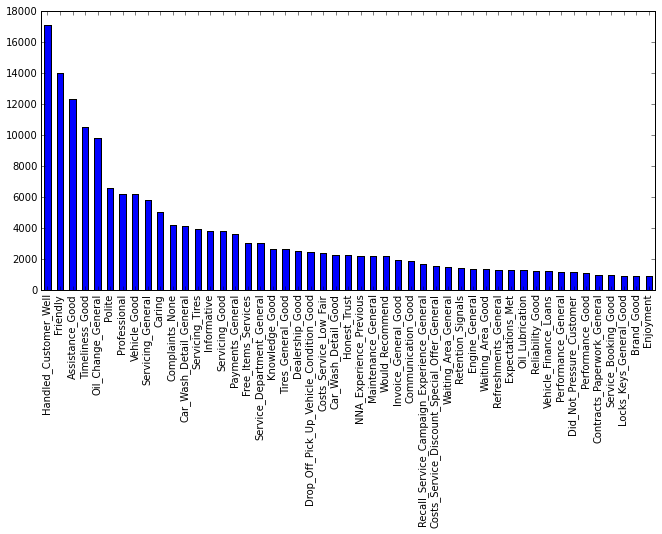

In [43]:
pos_df['perspective_name'].value_counts()[1:50].plot(kind='bar',figsize=(11,5))

In [7]:
pos_scores = pos_df[['response_id','nps_dealer_service_score']].drop_duplicates().set_index('response_id')

In [10]:
pos_px_table = (
            pos_df
            .groupby('response_id')
            .perspective_name
            .value_counts()
            .reset_index()
            .pivot(index='response_id',columns='level_1',values=0)
            .fillna(0)
            .assign(scores = pos_scores)
            .dropna()
)

#### Run the analysis, adapting target scores and decision threshhold, to determine optimal performance as measured by F1 Score.

In [15]:
def pos_metric_cube():
    results = []
    scores = range(5,10)
    pxs = range(50,51)
    threshholds = np.arange(0.1,1.0,0.1)
    for score, top_pxs, threshhold in product(scores, pxs, threshholds):
        metric = pos_logistic_regression2(pos_px_table, score, top_pxs, threshhold)
        results.append((metric, score, top_pxs, threshhold))
    results.sort(key = lambda x: x[0])
    print results[-1]
    
    
def pos_logistic_regression2(sample, score, top_pxs, threshhold):
       
    sample['promoter'] = (sample.scores > score).astype(int)
    
    cols = pos_df.perspective_name.value_counts().head(top_pxs).index
    model = smf.logit('promoter ~ {}'.format(' + '.join(cols)), sample).fit()
    
    probabilities = model.predict(sample)
    decisions = (probabilities > threshhold).astype(int)
    
    f1 = f1_score(sample.promoter, decisions)
    return f1

pos_metric_cube()

Optimization terminated successfully.
         Current function value: 0.314825
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.314825
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.314825
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.314825
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.314825
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.314825
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.314825
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.314825
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.314825
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.354527
  

#### The results of this analysis show that one can expect an F1 score of 93 if one looks for scores above 5, uses 50 predictor variables (perspectives), and uses 0.5 as the decision threshhold.

#### Rerun the logistic regression using these parameters, displaying the summary and other metrics including a confusion matrix.

In [16]:
def pos_logistic_regression(score, top_pxs, threshhold):

    pos_px_table['promoter'] = (pos_px_table.scores > score).astype(int)
    
    cols = pos_df.perspective_name.value_counts().head(top_pxs).index
    model = smf.logit('promoter ~ {}'.format(' + '.join(cols)), pos_px_table).fit()
    print model.summary()
    
    probabilities = model.predict(pos_px_table)
    decisions = (probabilities > threshhold).astype(int)
    
    accuracy = accuracy_score(pos_px_table.promoter, decisions)
    print '\nAccuracy Score: {}'.format(accuracy)
    
    recall = recall_score(pos_px_table.promoter, decisions)
    print '\nRecall Score: {}'.format(recall)
    
    precision = precision_score(pos_px_table.promoter, decisions)
    print '\nPrecision Score: {}'.format(precision)
    
    f1 = f1_score(pos_px_table.promoter, decisions)
    print '\nF1 Score: {}'.format(f1)
    
    cm = confusion_matrix(pos_px_table.promoter, decisions)
    print '\nConfusion Matrix:\n'
    print cm
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    tick_marks = np.arange(2)
    plt.xticks(tick_marks)
    plt.yticks(tick_marks)
    plt.ylabel('true')
    plt.xlabel('predicted')
    
    return model

Optimization terminated successfully.
         Current function value: 0.314825
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:               promoter   No. Observations:                78739
Model:                          Logit   Df Residuals:                    78688
Method:                           MLE   Df Model:                           50
Date:                Wed, 06 Apr 2016   Pseudo R-squ.:                  0.2011
Time:                        09:00:02   Log-Likelihood:                -24789.
converged:                       True   LL-Null:                       -31030.
                                        LLR p-value:                     0.000
                                                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------------------
Intercept                               

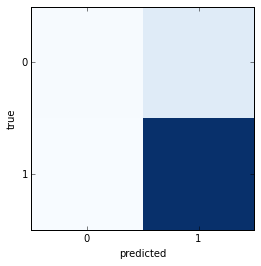

In [17]:
pos_model = pos_logistic_regression(5, 50, 0.5)

#### Sort the top 20 perspectives by coefficient to arrive at the top drivers of customer recommendation.

In [18]:
pos_model.params.order(ascending=False)[1:21]

Customer_Service_Good     1.242115
Car_Wash_Detail_Good      1.181158
Professional              0.933333
Friendly                  0.889318
Timeliness_Good           0.863917
Waiting_Area_Good         0.813581
Expectations_Met          0.765652
Reliability_Good          0.762476
Dealership_Good           0.579066
Polite                    0.573956
Handled_Customer_Well     0.552654
Informative               0.410079
Refreshments_General      0.397736
Assistance_Good           0.322238
Knowledge_Good            0.299379
Enjoyment                 0.220651
Performance_Good          0.216701
Caring                    0.207159
Costs_Service_Low_Fair    0.138712
Brand_Good                0.115550
dtype: float64

#### Conclusion

The results of this analysis show that for a customer to recommend the dealership to a friend or family member, they most appreciate a positive interpersonal interaction when they bring their cars in for service, though having their cars cleaned also makes a big impact. 

Staff hiring and training should focus on maximizing great people skills in order to make the biggest impact on word of mouth marketing for dealers. 

Further application of this analysis could be forecasting higher scores based on hypothetical increases in the volume of certain perspectives in surveys. For instance, if surveys with Professional comments increased by 25% at a specific dealership, how would that impact the overall recommendation score for that location? What other measures might also increase? What kind of increase in monthly sales or customer loyalty could be expected?